## Week 10 Lecture 2

We want to investigate a case study about environmental regulation. Commericial fishers will capture Dungeness crabs in the Pacific ocean. Regulator agencies monitor the capture of these crustaceans to prevent extinction. For sustainability fishers must release female crabs and young male crabs. Estimating the age of the crabs can be tough. Age relates to size. However size can fluctuate through seasonal molting of exoskeleton. Therefore biologists are interested in predicting the size of a crab before molting from the size of a crab after molting.  

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model

### Exercise (Correlation)

We have data about grades on an assignment. 

In [2]:
grades = pd.DataFrame(data = {
    "score": [25,20,22,15,25],
    "points": [0,5,3,10,0],
})
grades

,score,points
0,25,0
1,20,5
2,22,3
3,15,10
4,25,0


Before we generate a scatter-plot we need to scale the data to have standard deviation 1.

In [3]:
score_std = np.std(grades["score"])
points_std = np.std(grades["points"])

grades_scaled = grades.div([score_std, points_std])

We check that the columns have standard deviation 1. 

In [4]:
np.std(grades_scaled["score"])

1.0

In [5]:
np.std(grades_scaled["points"])

0.9999999999999999

We can us a scatter-plot to show the relationship between values. 

In [6]:
grades_scaled

,score,points
0,6.720042,0.000000
1,5.376033,1.344008
2,5.913637,0.806405
3,4.032025,2.688017
4,6.720042,0.000000


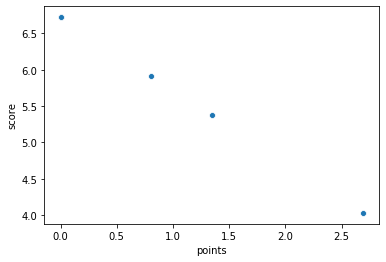

In [9]:
sns.scatterplot(grades_scaled["points"], grades_scaled["score"]);

Where is the fifth point?

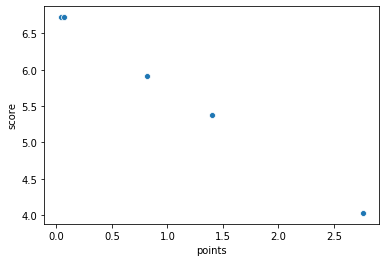

In [10]:
jitter = 0.1 * np.random.rand(len(grades_scaled))
sns.scatterplot(grades_scaled["points"] + jitter, grades_scaled["score"]);

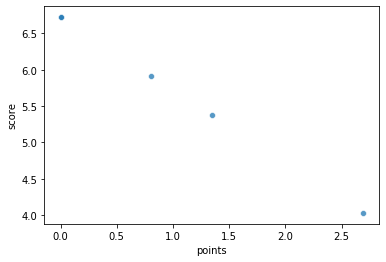

In [11]:
sns.scatterplot(grades_scaled["points"], grades_scaled["score"], alpha = 0.75);

We can compute the correlation from 
- standard derivation of points
- standard derivation of scores
- covariance of points and scores

In [12]:
variance_points = np.mean( (grades["points"] - np.mean(grades["points"]))**2 )
variance_score = np.mean( (grades["score"] - np.mean(grades["score"]))**2 )

In [13]:
covariance = np.mean( (grades["score"] - np.mean(grades["score"])) * (grades["points"] - np.mean(grades["points"])) )

In [14]:
correlation = covariance / (np.sqrt(variance_score) * np.sqrt(variance_points))

In [15]:
correlation

-0.9999999999999999

Alternatively we can use pandas

In [16]:
grades.corr()

,score,points
score,1.0,-1.0
points,-1.0,1.0


We know that $$\text{score} = 25 - \text{points}$$ So we can fit a line to the data to capture the linear relationship.

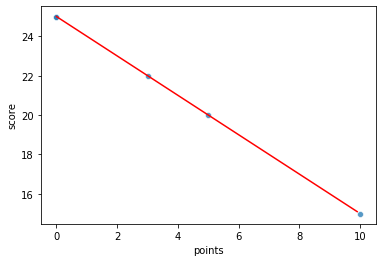

In [17]:
 sns.scatterplot(grades["points"], grades["score"], alpha = 0.75) #alpha changes hue of points
plt.plot(np.arange(0.0,10,0.1), 25 - np.arange(0.0,10,0.1), 'r');

What do you notice about the following quantity?

In [21]:
slope = correlation * ( np.sqrt(variance_score) / np.sqrt(variance_points) )
slope

-0.9999999999999998

This is the formula for the slope of the line. What do you notice about the following quantity?

In [23]:
np.mean(grades["score"]) - np.mean(grades["points"]) * slope

24.999999999999996

This is the intercept of the line

$$\underset{a,b}{\operatorname{min}} \; \frac{1}{n} \sum_{i=1}^n \; \left(y_i - (a + b x_i) \right)^2$$

### Example (Crab Growth)

We have data about the size of crab shells. The column `presz` measures the size in millimeters before molting. The column `postsz` measures the size in millimeters after molting.

In [56]:
crabs = pd.read_csv("crabs.tsv", sep = r"\s+", header = 0)

crabs

,presz,postsz,inc,year,lf
0,113.6,127.7,14.1,NaN,0
1,118.1,133.2,15.1,NaN,0
2,119.9,135.3,15.4,NaN,0
...,...,...,...,...,...
469,129.6,143.5,13.9,92.0,1
470,134.1,148.3,14.2,92.0,1
471,114.4,129.2,14.8,92.0,1


We can us a scatter-plot to show the relationship between pre-molt width and post-molt width. 

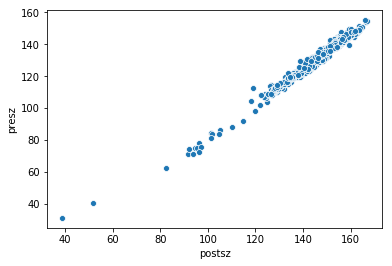

In [57]:
sns.scatterplot(crabs["postsz"], crabs["presz"]);

We can compute the correlation.

In [58]:
crabs[["presz", "postsz"]].corr()

,presz,postsz
presz,1.00000,0.99037
postsz,0.99037,1.00000


We can us a scatter-plot to show the relationship between post-molt width and increment. 

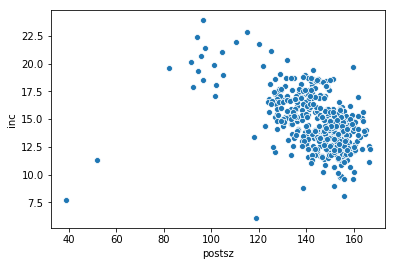

In [60]:
sns.scatterplot(crabs["postsz"], crabs["inc"]);

Note the outliers. We can omit post-molt width less than 120 millimeters.

In [112]:
crabs_no_outliers = crabs[crabs["postsz"] > 120]
crabs_no_outliers = crabs_no_outliers.copy()

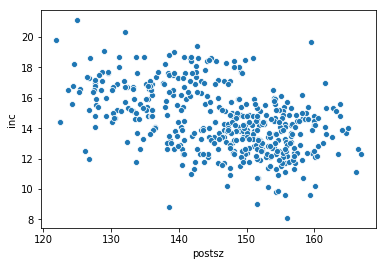

In [113]:
sns.scatterplot(crabs_no_outliers["postsz"], crabs_no_outliers["inc"]);

We have a negative correlation

In [117]:
crabs_no_outliers[["inc", "postsz"]].corr()

,inc,postsz
inc,1.000000,-0.461054
postsz,-0.461054,1.000000


Before using linear regression, we could try to aggregate the data to get an approximate trend in the data. We can use `pandas` to label each entry in the `postsz` column by quintile. Note that a quintile is a quantile where we have five subsets of the data. Think 20,40,60,80 and 100 percentile.

In [118]:
quintiles = pd.qcut(crabs_no_outliers["postsz"], 5)
quintiles 

0      (121.899, 136.5]
1      (121.899, 136.5]
2      (121.899, 136.5]
             ...       
469      (136.5, 144.6]
470      (144.6, 150.0]
471    (121.899, 136.5]
Name: postsz, Length: 451, dtype: category
Categories (5, interval[float64]): [(121.899, 136.5] < (136.5, 144.6] < (144.6, 150.0] < (150.0, 154.8] < (154.8, 166.8]]

In [119]:
crabs_no_outliers_quintiles = crabs_no_outliers[["inc", "postsz"]].groupby(quintiles).agg({"inc":np.mean, "postsz":np.median})
crabs_no_outliers_quintiles

,inc,postsz
postsz,,
"(121.899, 136.5]",15.994565,131.70
"(136.5, 144.6]",15.324444,140.85
"(144.6, 150.0]",14.335165,147.80
"(150.0, 154.8]",13.409091,152.50
"(154.8, 166.8]",13.476667,157.50


We can plot the results over the scatter-plot.

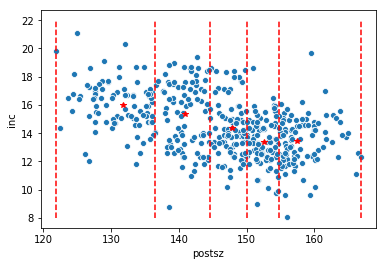

In [120]:
sns.scatterplot(crabs_no_outliers["postsz"], crabs_no_outliers["inc"])
plt.plot(crabs_no_outliers_quintiles["postsz"], crabs_no_outliers_quintiles["inc"], "r*")

for index in crabs_no_outliers_quintiles.index:
    plt.vlines(x = index.left, ymin=8, ymax=22, color = "r", linestyles="dashed")
    
plt.vlines(x = crabs_no_outliers_quintiles.index[-1].right, ymin=8, ymax=22, color = "r", linestyles="dashed");

We can determine the slope and intercept using the sci-kit learn package. 

In [121]:
linear_regression_solver = linear_model.LinearRegression()
linear_regression_solver.fit(crabs_no_outliers["postsz"].values.reshape(-1,1), crabs_no_outliers["inc"].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We obtain about -0.1 for the slope and 29 for the intercept

In [122]:
slope = linear_regression_solver.coef_[0][0]
slope

-0.10030539346290081

In [123]:
intercept = linear_regression_solver.intercept_[0]
intercept

29.17419825633771

In [124]:
def prediction(x):
    return intercept + slope * x

Using the predictions we can plot the fitted lines.

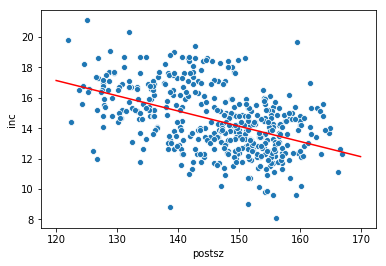

In [125]:
sns.scatterplot(crabs_no_outliers["postsz"], crabs_no_outliers["inc"])

xvalues = np.arange(120, 170, 0.1)
plt.plot(xvalues, prediction(xvalues), "r");

Remember that we need to compute the residuals.

In [126]:
crabs_no_outliers["prediction"] = crabs_no_outliers["postsz"].copy().map(prediction)

In [130]:
crabs_no_outliers["residuals"] = crabs_no_outliers["inc"] - crabs_no_outliers["prediction"]

We can check that the summation of the residuals is 0

In [143]:
crabs_no_outliers["residuals"].sum()

5.400124791776761e-13

We can check that the variance of the response variable `inc` decomposes into explained variance and unexplained variance. 

In [132]:
y_variance = np.std(crabs_no_outliers["inc"])**2
y_variance

4.589037713678886

In [133]:
y_explained_variance = np.std(crabs_no_outliers["prediction"])**2
y_explained_variance

0.975494162189155

In [134]:
y_unexplained_variance = np.std(crabs_no_outliers["residuals"])**2
y_unexplained_variance

3.613543551489733

In [137]:
y_explained_variance + y_unexplained_variance

4.589037713678888

We check that the residuals do not appear to have a pattern like funneling

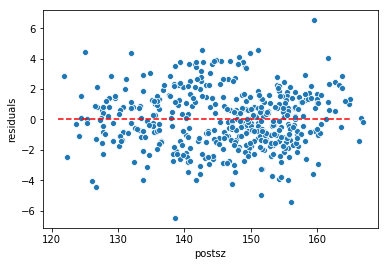

In [142]:
sns.scatterplot(crabs_no_outliers["postsz"], crabs_no_outliers["residuals"])
plt.hlines(y = 0, xmin = 121, xmax = 165, color = "r", linestyles="dashed");